# Vegetable Classification

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import random
import pathlib
import splitfolders
import seaborn as sns
import tensorflow as tf
from keras import backend as K
from tensorflow import keras as ks
from tensorflow.keras.models import Model
from keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Activation, BatchNormalization, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt       

from keras.preprocessing.image import ImageDataGenerator

from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
class_names = ['BellPepper', 'Lemon', 'Onion', 'Potato', 'Tomato']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

IMAGE_SIZE = (100, 100)
images = []
labels = []

In [3]:
train_dir = 'Train'
class_names = ['BellPepper', 'Lemon', 'Onion', 'Potato', 'Tomato']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
for folder in os.listdir(train_dir):
    label = class_names_label[folder]
    
    for file in tqdm(os.listdir(os.path.join(train_dir, folder))):
        img_path = os.path.join(os.path.join(train_dir, folder), file)
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, IMAGE_SIZE) 
        
        images.append(image)
        labels.append(label)
        
images = np.array(images, dtype = 'float32')
labels = np.array(labels, dtype = 'int32') 

images = images/255.0

100%|████████████████████████████████████████████████████████████████████████████| 1409/1409 [00:00<00:00, 4573.39it/s]


In [4]:
n_samples = labels.shape[0]
print ("Number of samples examples: {}".format(n_samples))

print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of samples examples: 6673
Each image is of size: (100, 100)


<AxesSubplot:>

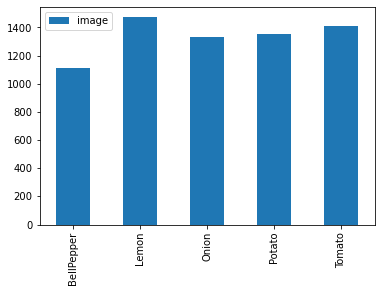

In [5]:

_,images_counts = np.unique(labels, return_counts=True)
pd.DataFrame({'image': images_counts}, index=class_names).plot.bar()


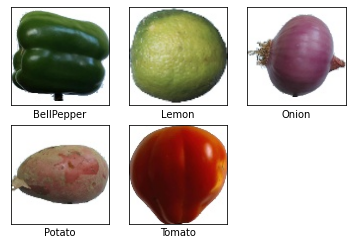

In [6]:
for i in range(len(class_names)):
    plt.subplot(2,3,i+1)
    plt.xticks([])
    plt.yticks([])
    
    array = np.where(labels == i)[0]
    rand = random.randint(0, len(array))
    arr = array[rand]  
    
    plt.imshow(images[arr], cmap=plt.cm.binary)
    plt.xlabel(class_names[labels[arr]])

In [7]:
base_ds = 'Train'
base_ds = pathlib.Path(base_ds)

In [8]:
splitfolders.ratio(base_ds, output='imgs', seed=123, ratio=(.7,.15,.15), group_prefix=None)

Copying files: 6673 files [00:03, 1746.90 files/s]


In [9]:
bellpepper = [fn for fn in os.listdir(f'{base_ds}/BellPepper') if fn.endswith('.jpg')]
lemon = [fn for fn in os.listdir(f'{base_ds}/Lemon') if fn.endswith('.jpg')]
onion = [fn for fn in os.listdir(f'{base_ds}/Onion') if fn.endswith('.jpg')]
potato = [fn for fn in os.listdir(f'{base_ds}/Potato') if fn.endswith('.jpg')]
tomato = [fn for fn in os.listdir(f'{base_ds}/Tomato') if fn.endswith('.jpg')]
vegetables = [bellpepper, lemon, onion, potato, tomato]
vegetable_classes = []
for i in os.listdir('imgs/train'):
    vegetable_classes+=[i]
vegetable_classes.sort()

In [10]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [11]:
batch_size = 128
img_height, img_width = 100, 100
input_shape = (img_height, img_width, 3)

In [12]:
datagen = ImageDataGenerator(rescale=1./255)

In [13]:
train_ds = datagen.flow_from_directory(
    'imgs/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
    class_mode='categorical')

val_ds = datagen.flow_from_directory(
    'imgs/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

test_ds = datagen.flow_from_directory(
    'imgs/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

Found 4669 images belonging to 5 classes.
Found 998 images belonging to 5 classes.
Found 1006 images belonging to 5 classes.


In [14]:
input_shape=(100, 100, 3)

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64,(3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(5, activation='softmax')
])


In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 98, 98, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 98, 98, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 98, 98, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 64)       0         
 )                                                               
                                                        

In [17]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

checkpointer = ModelCheckpoint(filepath='saved_models/model.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [18]:
history = model.fit(train_ds, epochs = 40, validation_data = val_ds, callbacks=callbacks)

Epoch 1/40
37/37 [==============================] - ETA: 0s - loss: 0.1153 - accuracy: 0.9623
Epoch 1: val_accuracy improved from -inf to 0.20240, saving model to saved_models\model.hdf5
37/37 [==============================] - 240s 6s/step - loss: 0.1153 - accuracy: 0.9623 - val_loss: 4.6980 - val_accuracy: 0.2024 - lr: 0.0010
Epoch 2/40
37/37 [==============================] - ETA: 0s - loss: 0.0375 - accuracy: 0.9901
Epoch 2: val_accuracy improved from 0.20240 to 0.28257, saving model to saved_models\model.hdf5
37/37 [==============================] - 241s 7s/step - loss: 0.0375 - accuracy: 0.9901 - val_loss: 7.1793 - val_accuracy: 0.2826 - lr: 0.0010
Epoch 3/40
37/37 [==============================] - ETA: 0s - loss: 0.0175 - accuracy: 0.9940
Epoch 3: val_accuracy did not improve from 0.28257
37/37 [==============================] - 240s 7s/step - loss: 0.0175 - accuracy: 0.9940 - val_loss: 6.0129 - val_accuracy: 0.2745 - lr: 0.0010
Epoch 4/40
37/37 [==============================]

Epoch 27/40
37/37 [==============================] - ETA: 0s - loss: 1.1220e-05 - accuracy: 1.0000
Epoch 27: val_accuracy did not improve from 1.00000
37/37 [==============================] - 253s 7s/step - loss: 1.1220e-05 - accuracy: 1.0000 - val_loss: 2.6046e-06 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 28/40
37/37 [==============================] - ETA: 0s - loss: 9.7212e-06 - accuracy: 1.0000
Epoch 28: val_accuracy did not improve from 1.00000
37/37 [==============================] - 241s 7s/step - loss: 9.7212e-06 - accuracy: 1.0000 - val_loss: 3.9261e-06 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 29/40
37/37 [==============================] - ETA: 0s - loss: 9.9907e-06 - accuracy: 1.0000
Epoch 29: val_accuracy did not improve from 1.00000
37/37 [==============================] - 253s 7s/step - loss: 9.9907e-06 - accuracy: 1.0000 - val_loss: 5.5422e-06 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 30/40
37/37 [==============================] - ETA: 0s - loss: 1.8388e-05 - accuracy: 1.

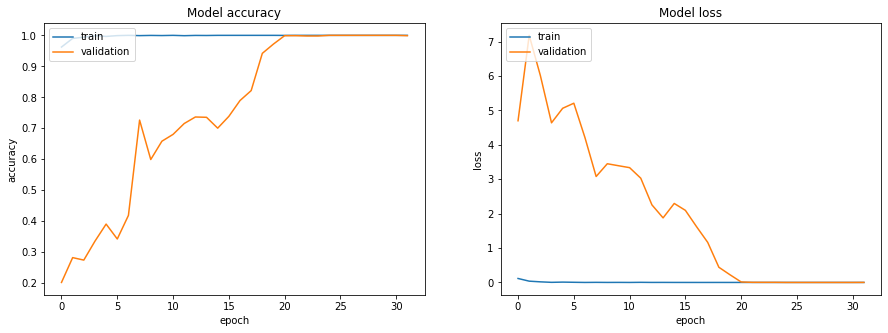

In [19]:
model.load_weights('saved_models/model.hdf5')
plot_train_history(history)

In [20]:
Y_pred = model.predict(test_ds)

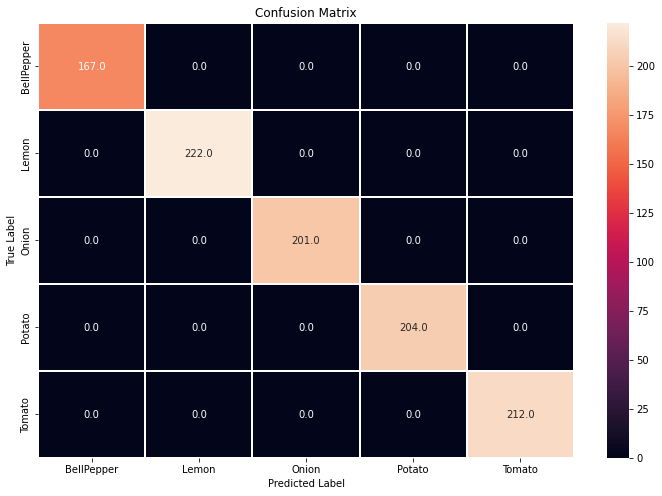

In [21]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 8))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(vegetable_classes)
plt.title("Confusion Matrix")
plt.show()


In [22]:
report = classification_report(test_ds.classes, y_pred, target_names=vegetable_classes, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
BellPepper,1.0,1.0,1.0,167.0
Lemon,1.0,1.0,1.0,222.0
Onion,1.0,1.0,1.0,201.0
Potato,1.0,1.0,1.0,204.0
Tomato,1.0,1.0,1.0,212.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,1006.0
weighted avg,1.0,1.0,1.0,1006.0


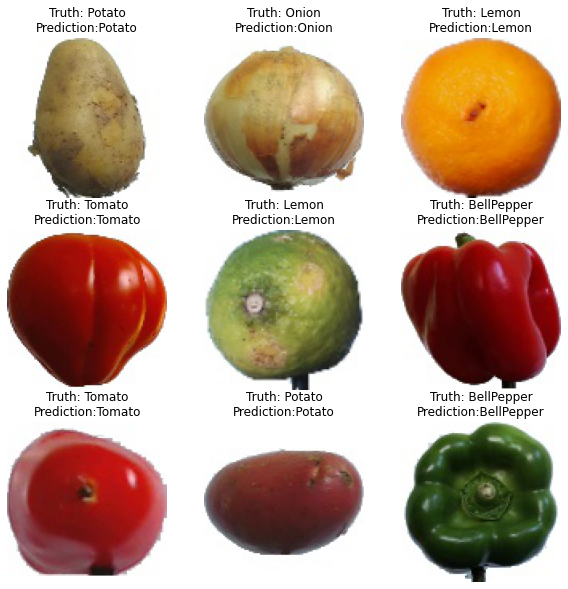

In [23]:
plt.figure(figsize=(10, 10))
x, label= train_ds.next()
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i]==1)
    predict = model(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label = vegetable_classes[np.argmax(score)]
    plt.title(f'Truth: {vegetable_classes[result[0][0]]}\nPrediction:{score_label}')
    plt.axis(False)